## Семинар 7: "Методы оптимизации"

ФИО: Сульженко Родион Вадимович

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline
from IPython.display import clear_output
import seaborn as sns

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [3]:
import abc

class Optimizer(abc.ABC):
    def __init__(self, list_params):
        self.params = list(list_params)
        
    def step(self, err):
        pass

    def finish(self):
        with torch.no_grad():
            for param in self.params:
                param.grad.data.zero_()

class GD(Optimizer):
    def __init__(self, list_params, lr):
        super().__init__(list_params)
        self.lr = lr
    
    def step(self, err):
        loss = err()
        loss.backward()
        with torch.no_grad():
            for param in self.params:
                param -= self.lr * param.grad
        self.finish()

class Momentum(GD):
    def __init__(self, list_params, lr, nu=0.1):
        super().__init__(list_params, lr)
        self.nu = nu
        self.vs = [torch.zeros_like(param) for param in self.params]

    def step(self, err):
        loss = err()
        loss.backward()
        with torch.no_grad():
            for v, param in zip(self.vs, self.params):
                v.copy_(self.nu * v + self.lr * param.grad)                
                param -= v
        self.finish()

class NAG(GD):
    def __init__(self, list_params, lr, nu=0.1):
        super().__init__(list_params, lr)
        self.nu = nu
        self.vs = [torch.zeros_like(param) for param in self.params]
    
    def step(self, err):
        with torch.no_grad():
            for v, param in zip(self.vs, self.params):
                param -= self.nu * v
        loss = err()
        loss.backward()

        with torch.no_grad():
            for v, param in zip(self.vs, self.params):
                param += self.nu * v
                v.copy_(self.nu * v + self.lr * param.grad) 
                param -= v
        self.finish()

class RMSProp(GD):
    def __init__(self, list_params, lr, gamma=0.9):
        super().__init__(list_params, lr)
        self.gamma = gamma
        self.g_sq_list = [torch.zeros_like(param) for param in self.params]
        self.eps = 10**-8

    def step(self, err):
        loss = err()
        loss.backward()

        with torch.no_grad():
            for g_sq, param in zip(self.g_sq_list, self.params):
                g_sq.copy_(self.gamma * g_sq + (1 - self.gamma) * param.grad**2)
                param -= self.lr * param.grad / (g_sq + self.eps)**0.5
        self.finish()
        
        
class Adagrad(GD):
    def __init__(self, list_params, lr):
        super().__init__(list_params, lr)
        self.g_sq_list = [torch.zeros_like(param) for param in self.params]
        self.eps = 10 ** -8

    def step(self, err):
        loss = err()
        loss.backward()
    
        with torch.no_grad():
            for g_sq, param in zip(self.g_sq_list, self.params):
                g_sq.copy_(g_sq + param.grad ** 2)
                param -= self.lr * param.grad / (g_sq + self.eps) ** 0.5
        self.finish()
    

class Adadelta(Optimizer):
    def __init__(self, list_params, learning_rate, gamma=0.9):
        super().__init__(list_params)
        self.gamma = gamma
        self.d_t = [torch.zeros_like(param) for param in self.params]
        self.previous_params = [torch.zeros_like(param) for param in self.params]
        self.g_sq_list = [torch.zeros_like(param) for param in self.params]
        self.eps = 10 ** -8

    def step(self, err):
        loss = err()
        loss.backward()

        with torch.no_grad():
            for g_sq, d_t, previous_param, param in zip(self.g_sq_list, self.d_t,
                                                    self.previous_params, self.params):
                g_sq.copy_(self.gamma * g_sq + (1 - self.gamma) * param.grad ** 2)
                delta = ((d_t + self.eps) / (g_sq + self.eps)) ** 0.5 * param.grad 
                d_t.copy_(self.gamma * d_t + (1 - self.gamma) * (param - previous_param) ** 2)
                previous_param.copy_(param)
                param -= delta
        self.finish()

class Adam(Optimizer):
    def __init__(self, list_params, lr, beta1=0.9, beta2=0.999):
        super().__init__(list_params)
        self.lr = lr
        self.eps = 10 ** -8
        self.beta1 = beta1
        self.beta2 = beta2
        
        self.mt = [torch.zeros_like(param) for param in self.params]
        self.vt = [torch.zeros_like(param) for param in self.params]
        self.t = 0
    
    def step(self, err):
        loss = err()
        loss.backward()
        self.t += 1
        
        with torch.no_grad():
            for mt, vt, param in zip(self.mt, self.vt, self.params):
                mt.copy_(self.beta1 * mt + (1 - self.beta1) * param.grad)
                vt.copy_(self.beta2 * vt + (1 - self.beta2) * param.grad ** 2)
                mt_hat = mt / (1.0 - self.beta1 ** self.t)
                vt_hat = vt / (1.0 - self.beta2 ** self.t)
                
                param -= self.lr * param.grad / (vt_hat + self.eps) ** 0.5
        self.finish()

In [4]:
type(np.array([0]))

numpy.ndarray

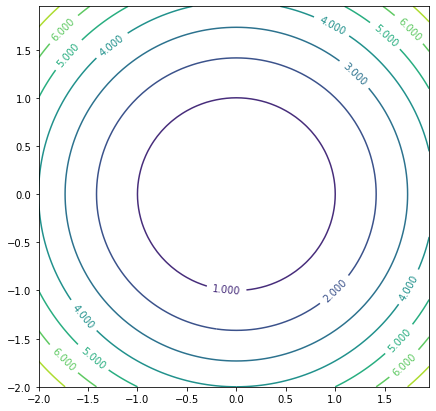

In [5]:
def J_1(x, y):
    return x**2 + y**2

def plot_contour(J, xb=-2, xt=2, yb=-2, yt=2, delta=0.05):
    x = np.arange(xb, xt, delta)
    y = np.arange(yb, yt, delta)
    X, Y = np.meshgrid(x, y)
    
    Z = np.array([J(x[0], x[1]) for x in np.c_[X.reshape(-1,1), Y.reshape(-1,1)]]).reshape(X.shape[0], X.shape[1])
    CS = plt.contour(X, Y, Z)
    plt.clabel(CS, inline=1, fontsize=10)
    
plt.figure(figsize=(7,7))
plot_contour(J_1, xb=-2, xt=2, yb=-2, yt=2, delta=0.05)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

tensor([1.1330e-16], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([1.0828e-18], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([1.2011e-18], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([31.1011], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([4.9995e-05], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1756], dtype=torch.float64, grad_fn=<AddBackward0>)


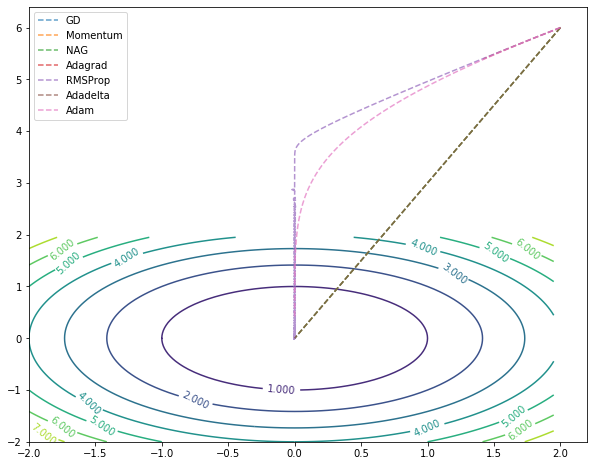

In [6]:
############
def make_var(x):
    x = np.array([float(x)])
    x = torch.from_numpy(x)
    return torch.autograd.Variable(x, requires_grad=True)

x, y = make_var(1), make_var(2)

def err(J=J_1, x=x, y=y):
    return J(x, y)

learning_rate = 0.01

optimizers = {
    'GD': GD([x, y], learning_rate),
    'Momentum': Momentum([x, y], learning_rate),
    'NAG': NAG([x, y], learning_rate),
    'Adagrad': Adagrad([x, y], learning_rate),
    'RMSProp': RMSProp([x, y], learning_rate),
    'Adadelta': Adadelta([x, y], learning_rate),
    'Adam': Adam([x, y], learning_rate)
}

all_points = []

plt.figure(figsize=(10, 8))
plot_contour(J_1, xb=-2, xt=2, yb=-2, yt=2, delta=0.05)

for opt_name, optim in optimizers.items():
    with torch.no_grad():
        x.copy_(torch.tensor(2))
        y.copy_(torch.tensor(6))

    points = []
    
    for i in range(1000):
        points.append((x.item(), y.item()))
        optim.step(err)
    print(err())
    points = np.array(points)
    
    plt.plot(points[:, 0], points[:, 1], label=opt_name, alpha=0.7, linestyle='--')

    
    all_points.append(points)
    
plt.legend()
plt.show()

Замечу, что Adagrad сходится, если поставить большее число эпох и выбрать другое начальное приближение. В данном случае градиент затухает раньше, чем доходим до оптимума. Это происходит потому что g_sq - неубывает и через определенное число шагов веса практически не будут обновляться

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [7]:
def J_2(x, y):
    return x**2 * x.sin() + y**2 * y.sin()
def J_2_for_contour(x, y):
    return x**2 * np.sin(x) + y**2 * np.sin(y)

tensor([7.0232e-05], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([5.1304e-05], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([5.1411e-05], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8137], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([1.8176e-16], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([1.0027e-10], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([4.3436e-05], dtype=torch.float64, grad_fn=<AddBackward0>)


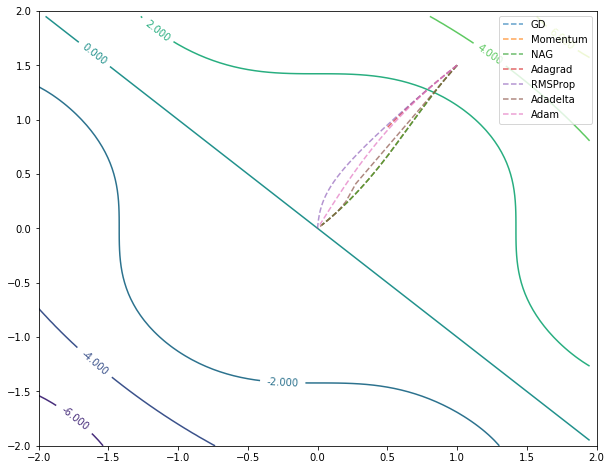

In [8]:
############
def make_var(x):
    x = np.array([float(x)])
    x = torch.from_numpy(x)
    return torch.autograd.Variable(x, requires_grad=True)

x, y = make_var(1), make_var(2)

def err(J=J_2, x=x, y=y):
    return J(x, y)

learning_rate = 0.01


optimizers = {
    'GD': GD([x, y], learning_rate),
    'Momentum': Momentum([x, y], learning_rate),
    'NAG': NAG([x, y], learning_rate),
    'Adagrad': Adagrad([x, y], learning_rate),
    'RMSProp': RMSProp([x, y], learning_rate),
    'Adadelta': Adadelta([x, y], learning_rate),
    'Adam': Adam([x, y], learning_rate)
}

all_points = []

plt.figure(figsize=(10, 8))

plot_contour(J_2_for_contour, xb=-2, xt=2, yb=-2, yt=2, delta=0.05)

for opt_name, optim in optimizers.items():
    with torch.no_grad():
        x.copy_(torch.tensor(1))
        y.copy_(torch.tensor(1.5))

    points = []
    
    for i in range(1000):
        points.append((x.item(), y.item()))
        optim.step(err)
    print(err())
    points = np.array(points)
    
    plt.plot(points[:, 0], points[:, 1], label=opt_name, alpha=0.7, linestyle='--')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    
    all_points.append(points)
    
plt.legend()
plt.show()

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [9]:
def J_3(x, y):
    return x**2 * ((x ** 2)).sin() + y**2 * ((y ** 2).sin())
def J_3_for_contour(x, y):
    return x**2 * np.sin(x ** 2) + y**2 * np.sin(y ** 2)

tensor([0.0002], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0002], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0002], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0840], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([4.4528e-12], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([2.7477e-08], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([4.8667e-05], dtype=torch.float64, grad_fn=<AddBackward0>)


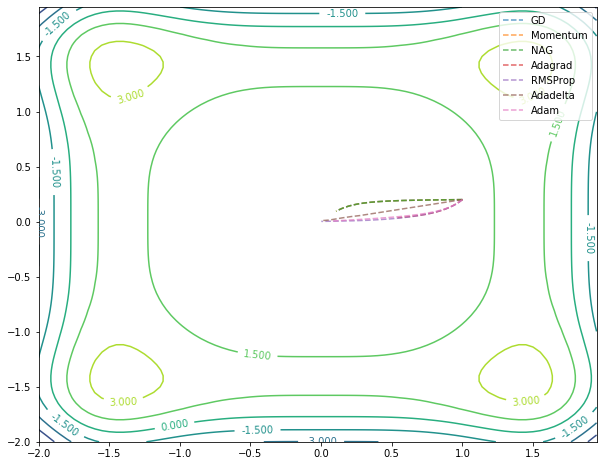

In [10]:
############
def make_var(x):
    x = np.array([float(x)])
    x = torch.from_numpy(x)
    return torch.autograd.Variable(x, requires_grad=True)

x, y = make_var(1), make_var(2)

def err(J=J_3, x=x, y=y):
    return J(x, y)

learning_rate = 0.01


optimizers = {
    'GD': GD([x, y], learning_rate),
    'Momentum': Momentum([x, y], learning_rate),
    'NAG': NAG([x, y], learning_rate),
    'Adagrad': Adagrad([x, y], learning_rate),
    'RMSProp': RMSProp([x, y], learning_rate),
    'Adadelta': Adadelta([x, y], learning_rate),
    'Adam': Adam([x, y], learning_rate)
}

all_points = []

plt.figure(figsize=(10, 8))

plot_contour(J_3_for_contour, xb=-2, xt=2, yb=-2, yt=2, delta=0.05)

for opt_name, optim in optimizers.items():
    with torch.no_grad():
        x.copy_(torch.tensor(1))
        y.copy_(torch.tensor(0.2))

    points = []
    
    for i in range(1000):
        points.append((x.item(), y.item()))
        optim.step(err)
    print(err())
    points = np.array(points)
    
    plt.plot(points[:, 0], points[:, 1], label=opt_name, alpha=0.7, linestyle='--')
    #plt.xlim(-2, 2)
    #plt.ylim(-2, 2)
    
    all_points.append(points)
    
plt.legend()
plt.show()

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [11]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from tqdm import tqdm

In [12]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('MNIST', train=True, download=False, transform=transform)
test_dataset = MNIST('MNIST', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [13]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [15]:
from tqdm import tqdm
def train(network, epochs, learning_rate, optim, ravel_init=True):
    loss = nn.NLLLoss()
    optimizer = optim(network.parameters(), learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            network.train()
            losses = []
            accuracies = []
            for X, y in train_loader:
                if ravel_init:
                    X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                
                loss_batch.backward(retain_graph=True)
                optimizer.step(lambda :loss(prediction, y))
                
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            network.eval()
            losses = []
            accuracies = []    
            for X, y in test_loader:
                if ravel_init:
                    X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
        return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs
    except KeyboardInterrupt:
        pass

In [30]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())
tr_l_adam, tt_l_adam, tr_acc_adam, tt_acc_adam = train(network, epochs=5, learning_rate=0.01, optim=Adam)

Epoch 4... (Train/Test) NLL: 0.218/0.209	Accuracy: 0.947/0.954


In [31]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())
tr_l_adagrad, tt_l_adagrad, tr_acc_adagrad, tt_acc_adagrad = train(network, epochs=5, learning_rate=0.01, optim=Adagrad)

Epoch 4... (Train/Test) NLL: 0.066/0.083	Accuracy: 0.980/0.972


In [32]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())
tr_l_adadelta, tt_l_adadelta, tr_acc_adadelta, tt_acc_adadelta = train(network, epochs=5, learning_rate=0.01, optim=Adadelta)
#######################

Epoch 4... (Train/Test) NLL: 0.131/0.132	Accuracy: 0.961/0.961


In [33]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())
tr_l_sgd, tt_l_sgd, tr_acc_sgd, tt_acc_sgd = train(network, epochs=5, learning_rate=0.1, optim=GD)

Epoch 4... (Train/Test) NLL: 0.053/0.099	Accuracy: 0.983/0.971


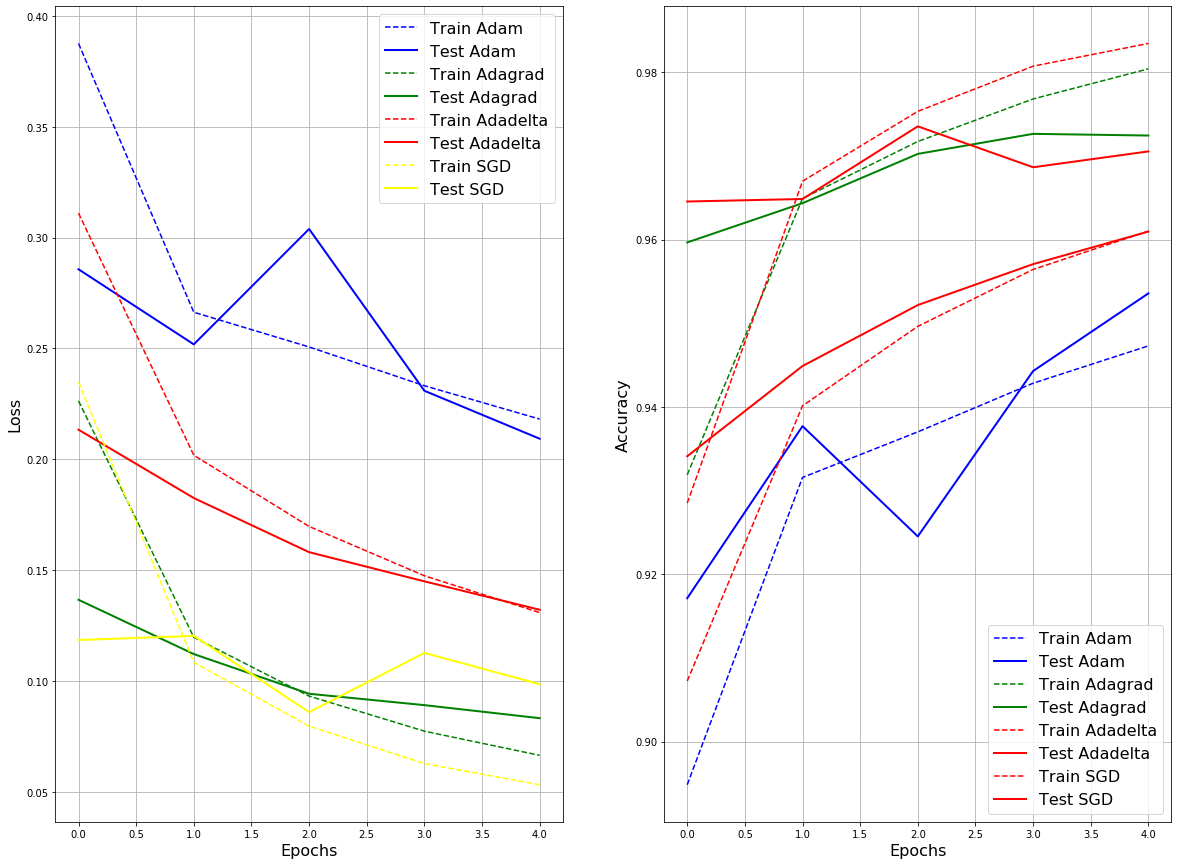

In [34]:
plt.figure(figsize=(20, 15))

plt.subplot(1, 2, 1)

plt.plot(tr_l_adam, linestyle='dashed', label='Train Adam', color='blue')
plt.plot(tt_l_adam, label='Test Adam', linewidth=2, color='blue')

plt.plot(tr_l_adagrad, linestyle='dashed', label='Train Adagrad', color='green')
plt.plot(tt_l_adagrad, label='Test Adagrad', linewidth=2, color='green')

plt.plot(tr_l_adadelta, linestyle='dashed', label='Train Adadelta', color='red')
plt.plot(tt_l_adadelta, label='Test Adadelta', linewidth=2, color='red')

plt.plot(tr_l_sgd, linestyle='dashed', label='Train SGD', color='yellow')
plt.plot(tt_l_sgd, label='Test SGD', linewidth=2, color='yellow')

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)

plt.legend(loc='best', fontsize=16)
plt.grid('on')





plt.subplot(1, 2, 2)

plt.plot(tr_acc_adam, linestyle='dashed', label='Train Adam', color='blue')
plt.plot(tt_acc_adam, label='Test Adam', linewidth=2, color='blue')

plt.plot(tr_acc_adagrad, linestyle='dashed', label='Train Adagrad', color='green')
plt.plot(tt_acc_adagrad, label='Test Adagrad', linewidth=2, color='green')

plt.plot(tr_acc_adadelta, linestyle='dashed', label='Train Adadelta', color='red')
plt.plot(tt_acc_adadelta, label='Test Adadelta', linewidth=2, color='red')

plt.plot(tr_acc_sgd, linestyle='dashed', label='Train SGD', color='red')
plt.plot(tt_acc_sgd, label='Test SGD', linewidth=2, color='red')


plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

plt.legend(loc='best', fontsize=16)
plt.grid('on')



plt.show()


<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [35]:
# 2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 ->
# -> ReLU -> ravel -> Linear -> LogSoftmax

image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(in_channels=channels, 
                                                   out_channels=8, 
                                                   kernel_size=3, 
                                                   padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(in_channels=8, 
                                                   out_channels=16,
                                                   kernel_size=3,
                                                   padding=1),
                                         nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*16, 10), 
                                           nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [36]:
network = ConvClassifier(image_size=28)
tr_l_adam, tt_l_adam, tr_acc_adam, tt_acc_adam = train(network, epochs=5, 
                                                       learning_rate=1e-4, 
                                                       optim=Adam, 
                                                       ravel_init=False)

Epoch 4... (Train/Test) NLL: 0.088/0.071	Accuracy: 0.974/0.977


In [37]:
network = ConvClassifier(image_size=28)
tr_l_adagrad, tt_l_adagrad, tr_acc_adagrad, tt_acc_adagrad = train(network, epochs=5,
                                                                   learning_rate=1e-4, 
                                                                   optim=Adagrad,
                                                                   ravel_init=False)

Epoch 4... (Train/Test) NLL: 0.720/0.663	Accuracy: 0.841/0.859


In [38]:
network = ConvClassifier(image_size=28)
tr_l_adadelta, tt_l_adadelta, tr_acc_adadelta, tt_acc_adadelta = train(network, epochs=5,
                                                                       learning_rate=1e-4, 
                                                                       optim=Adadelta,
                                                                       ravel_init=False)

Epoch 4... (Train/Test) NLL: 0.064/0.056	Accuracy: 0.981/0.983


In [39]:
network = ConvClassifier(image_size=28)
tr_l_sgd, tt_l_sgd, tr_acc_sgd, tt_acc_sgd = train(network, epochs=5,
                                                   learning_rate=1e-4, 
                                                   optim=GD,
                                                   ravel_init=False)

Epoch 4... (Train/Test) NLL: 0.386/0.352	Accuracy: 0.889/0.901


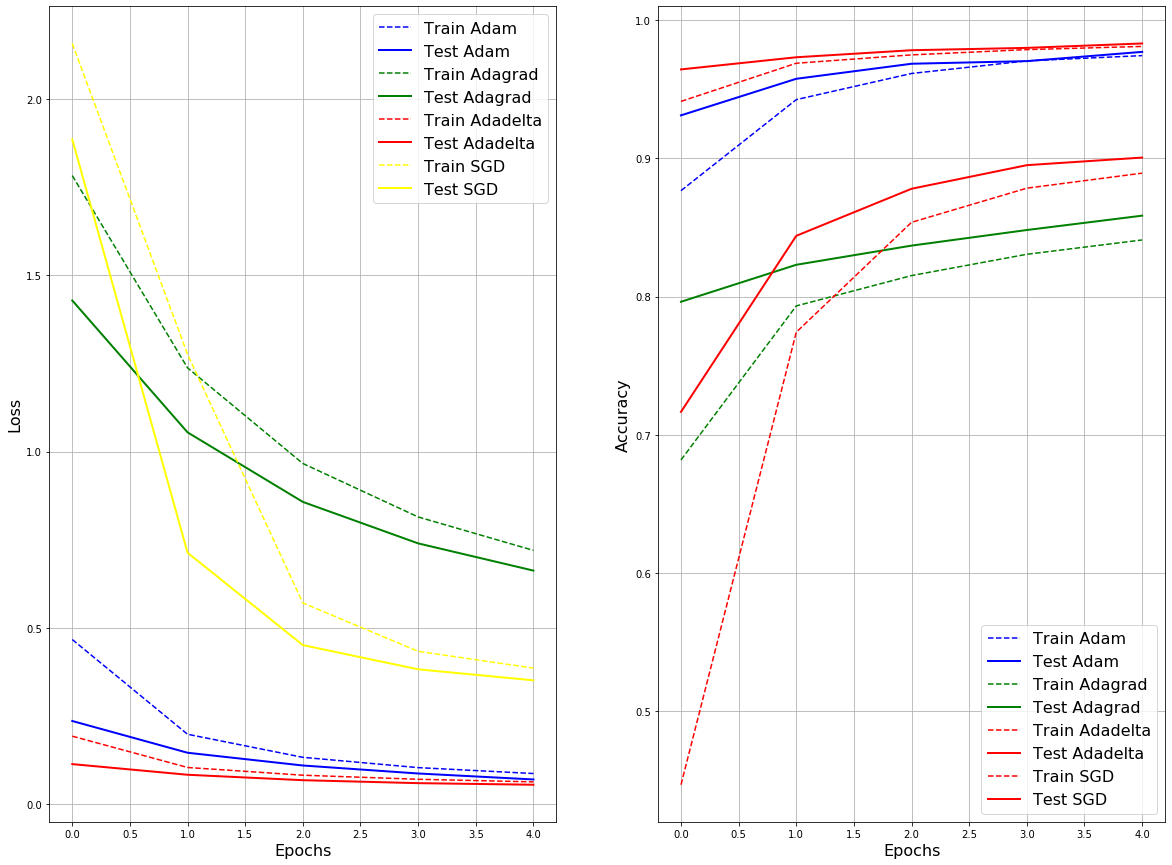

In [40]:
plt.figure(figsize=(20, 15))

plt.subplot(1, 2, 1)

plt.plot(tr_l_adam, linestyle='dashed', label='Train Adam', color='blue')
plt.plot(tt_l_adam, label='Test Adam', linewidth=2, color='blue')

plt.plot(tr_l_adagrad, linestyle='dashed', label='Train Adagrad', color='green')
plt.plot(tt_l_adagrad, label='Test Adagrad', linewidth=2, color='green')

plt.plot(tr_l_adadelta, linestyle='dashed', label='Train Adadelta', color='red')
plt.plot(tt_l_adadelta, label='Test Adadelta', linewidth=2, color='red')

plt.plot(tr_l_sgd, linestyle='dashed', label='Train SGD', color='yellow')
plt.plot(tt_l_sgd, label='Test SGD', linewidth=2, color='yellow')

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)

plt.legend(loc='best', fontsize=16)
plt.grid('on')





plt.subplot(1, 2, 2)

plt.plot(tr_acc_adam, linestyle='dashed', label='Train Adam', color='blue')
plt.plot(tt_acc_adam, label='Test Adam', linewidth=2, color='blue')

plt.plot(tr_acc_adagrad, linestyle='dashed', label='Train Adagrad', color='green')
plt.plot(tt_acc_adagrad, label='Test Adagrad', linewidth=2, color='green')

plt.plot(tr_acc_adadelta, linestyle='dashed', label='Train Adadelta', color='red')
plt.plot(tt_acc_adadelta, label='Test Adadelta', linewidth=2, color='red')

plt.plot(tr_acc_sgd, linestyle='dashed', label='Train SGD', color='red')
plt.plot(tt_acc_sgd, label='Test SGD', linewidth=2, color='red')


plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

plt.legend(loc='best', fontsize=16)
plt.grid('on')



plt.show()


- В принципе, методы показывают себя примерно одинаково.
- На подобранной скорости обучения результат с применением Adam значительно лучше

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: